# Imbalanced classes — ranking

In the their paper *Tackling Class Imbalance with Ranking*<sup>[1]</sup>, Cruz _et al._ introduce a series of algorithms that approach dealing with class imbalance by using methods that used for ranking data. These approaches are built on top of either linear support vector machines (SVM), AdaBoost, or neural networks.

These ranking methods make pairwise comparisions between points from different classes, these comparisions are inherently balanced. The authors demonstrate that on some datasets ranking can outperform instance weights, MetaCost and SMOTE. And, as the authors discuss, it is often the case with humans that we find it easier to produce rankings than to produce absolute scores, for example a human might find it easier to rank a series of candidates applying for a job in terms of their suitability rather than saying whether an individual candiate was definitely suitable.

In this notebook I demonstrate the principles behind their approach by applying their SVM-based algorithm to a simple example problem.

[1]:http://vcmi.inescporto.pt/reproducible_research/ijcnn2016/ClassImbalance/imbalance.pdf

In [1]:
from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import combinations
from imblearn.datasets import make_imbalance

from sklearn.svm import SVC
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

# Define a function for plotting data.
def plot_data(X, y):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], alpha=0.5)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], alpha=0.5)
    plt.show()

## Example problem

Below (following the example shown in the introduction) an imblanced classification problem is produced using the cresent moon dataset generator from *sklean* and the routines from *imblearn* that take a dataset and make it imbalanced.

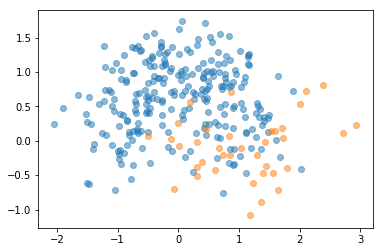

In [2]:
# Based on the imbalance_learn package examples
X, y = make_moons(n_samples=500, shuffle=True, noise=0.4, random_state=40)
X_, y_ = make_imbalance(X, y, ratio=0.15, min_c_=1, random_state=40)

plot_data(X_, y_)

The data can be split into training and test sets and then a linear support vector machine fitted. F1-score can then be used to look at the efficacy of the model.

In [3]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.33, random_state=3, stratify=y_)

# Define and fit model
model = SVC(kernel='linear', random_state=40)
model.fit(X_train, y_train)

# Make predictions
y_predict = model.predict(X_test)

# Output the precision, recall and f1-score
print classification_report(y_true=y_test, y_pred=y_predict)

             precision    recall  f1-score   support

          0       0.89      0.99      0.94        83
          1       0.67      0.17      0.27        12

avg / total       0.86      0.88      0.85        95



## Converting into a ranking problem

The central idea is to convert this into a ranking problem. In a ranking problem you say that instance $i$ is preferred to instance $j$ if the rank of $i$ is higher, and this is phrased as a classification problem by writting the features and values as:
$$(x_i, x_j), \,\, y_{ij}$$
where $x_i$ are the features associated with instance $i$ and $y_{ij}$ is either 1 if $i$ is preferred to $j$ or 0 otherwise. Normally in practice the features used are instead the differences between the features of each pair, *i.e.* $x_i - x_j$.

To convert are classification problem into a ranking problem we can say that class 1 has a higher rank than class 0. Then all permutations of pairs of instances in our dataset are considered where the class of the two instances differ. By only considering pairs where classes differ we ensure that the classes of the new problem are equally balanced.

To demonstrate, consider the instances $a$ and $b$ where $a$ is in the minority class (1) and $b$ is in the majority class. The features and values from these two points are:
$$(x_a - x_b),\,\, 1$$
$$(x_b - x_a),\,\, 0$$

so these two instances produce two features (one of each class) in the new feature space.

Let's define a function that considers all pairs and creates the new features and target values.

In [4]:
# Make a 1d array into a 2d array for the purposes of contanation
def make_1d_2d(a):
    return np.reshape( a, (-1, len(a)) ) 

# Add an array as a row to a matrix
def add_row(matrix, row):
    return np.vstack( (matrix, make_1d_2d(row)))

# Add a value to a numpy array
def add_value(vector, value):
    return np.hstack( (vector, np.array(value)))

def make_pairwise(X, y):
    # Create two empty arrays with the right shape
    X_rank = np.empty([0, X.shape[1]])
    y_rank = np.empty([0,])

    # Loop over pairs
    for (i, j) in combinations(range(X.shape[0]), 2):
        if y[i] != y[j]:
            X_rank = add_row(X_rank, X[i] - X[j])
            X_rank = add_row(X_rank, X[j] - X[i])
            y_rank = add_value(y_rank, y[i])
            y_rank = add_value(y_rank, y[j])
            
    return X_rank, y_rank

As shown below, running this function on our training data does produce balanced classes.

Number of points with class 0: 4175
Number of points with class 1: 4175


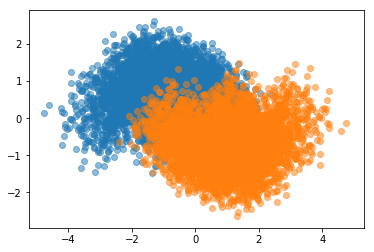

In [5]:
X_rank, y_rank = make_pairwise(X_train, y_train)

print "Number of points with class 0:", (y_rank == 0).sum()
print "Number of points with class 1:", (y_rank == 1).sum()

plot_data(X_rank, y_rank)

The classes are clearly balanced but this new ranking problem has a lot more datapoints than the original problem (in this case more than if we had simply oversampled the data). This makes training a classifier on the transformed data computationally expensive and demonstrates one of the drawbacks to the ranking approach.

As will be seen below, using a linear model is important as some of the steps that follow on will assume that the model in question is linear. Here a linear SVM is used.

In [6]:
model = SVC(kernel='linear', probability=True, random_state=40)
model.fit(X_rank, y_rank)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=40, shrinking=True,
  tol=0.001, verbose=False)

## How to make predictions

This model has been fit on the transformed training data which consists of differences between all the features in the training data. How do we then use this model to make prediciton on the test data?

The answer lies in model being linear, because of this we can write:

$$ f\left( x_i - x_j \right) = f\left( x_i \right) - f\left( x_j \right)$$

where the function $f$ represents the model making a probability prediction. This means that if we put an untransformed data point into the model the output is meaningful, it should not be thought of as a probability but as a ranking score where the differences between these scores tells you whether a point should be preferred to another one (when thought of in terms of ranking), where in this case if one point is preferred over another it indicates that it is more likely to belong to the minority class.

We need to apply a threshold to the ranking score above which a point should be considered to be in the minority class. As shown in the original paper this can be approximately determined by calculating the ranking scores on the training data, ordering the data by this score, and trying all thresholds between two points choosing the one that produces the best f1-score.

Below a function is defined that finds this threshold, as is a funtion that uses it to make predictions.

In [7]:
def make_predict(model, data, threshold):
    probs = model.predict_proba(data)
    return [1 if prob[1] > threshold else 0 for prob in probs]

def find_threshold(X_train, y_train, model):
    
    # Create a score for each element in the training data
    score = model.predict_proba(X_train)
    score = [value[1] for value in score]
    
    # Store the scores and classes in a dataframe, sort on score
    df = pd.DataFrame()
    df['class'] = y_train
    df['score'] = score
    df.sort_values('score', ascending=True, inplace=True)
    
    # Loop over all rows in the dataframe (but not the first)
    for x in xrange(1, len(df)):
        
        # Consider a canidate threshold as being between the scores
        # of the given row and the previous row, calculate its f1 score
        threshold_new = (df.loc[x-1, 'score'], df.loc[x, 'score'])
        threshold_approx = (threshold_new[0] + threshold_new[1])/2
        
        y_predict = [1 if value > threshold_approx else 0 for value in score]
        f1_new = f1_score(y_pred=y_predict, y_true=y_train, average='weighted')
        
        # Retain the best threshold (largest f1 score)
        if x==1:
            threshold = threshold_new
            f1 = f1_new
        elif f1_new > f1:
            threshold = threshold_new
            f1 = f1_new

    return threshold


Using this threshold-finding function suggests the threshold falls in this range:

In [8]:
# Find the best threshold beased on training data
threshold = find_threshold(X_train, y_train, model)
print "Threshold range:", threshold

Threshold range: (0.97292837088898121, 0.56595330689720047)


The threshold can be approximated by taking the mid-point of these two values and then used to make predicitons on the test data.

In [9]:
threshold_approx = (threshold[0] + threshold[1])/2

# Make predictions on training data using threshold
y_predict = make_predict(model, X_test, threshold_approx)
print classification_report(y_true=y_test, y_pred=y_predict)

             precision    recall  f1-score   support

          0       0.97      0.93      0.95        83
          1       0.62      0.83      0.71        12

avg / total       0.93      0.92      0.92        95



Calculating this threshold involved trying out all possible values which could be computationaly prohibitive if the training data is large (fortunately this is the original training data not the pairwise transformed training data). And the output of this routine can be quite a large range of values. In practice this threshold can be considered as another hyperparameter.